# **Capítulo 2 - Projeto de Aprendizado de Máquina de Ponta a Ponta**

Neste capítulo, você vai passar por um projeto de exemplo de ponta a ponta, fingindo ser um cientista de dados recém-contratado em uma empresa imobiliária. As principais etapas do projeto serão:

1. Olhe para o quadro geral. 
2. Obtenha os dados. 
3. Descubra e visualize os dados para obter insights.
4. Prepare os dados para algoritmos de aprendizado de máquina. 
5. Selecione um modelo e treine-o. 
6. Ajuste seu modelo. 
7. Apresente sua solução.
8. Inicie, monitore e mantenha seu sistema.

Neste capítulo, escolhemos o conjunto de dados California Housing Price do repositório StatLib. Este conjunto de dados foi baseado em dados do Censo de 1990 na Califórnia. Não é exatamente recente, mas tem muitas qualidades para o aprendizado, então vamos fingir que são dados recentes. Também adicionamos um atributo categórico e removemos alguns recursos para fins de ensino.

# 1 Olhe para o Quadro Geral

Seu modelo deve aprender com dados do censo da California e ser capaz de prever o preço médio da habitação em qualquer distrito, dadas todas as outras métricas.

## 1.1 Enquadre o Problema

A primeira pergunta a fazer ao seu chefe é qual é exatamente o objetivo do negócio; construir um modelo provavelmente não é o objetivo final. Como a empresa espera usar e se beneficiar deste modelo? Isso é importante pois determinará como você enquadrará o problema, quais algoritmos você selecionará, que medida de desempenho usará para avaliar seu modelo e quanto esforço você deve despender para ajustá-lo.

Seu chefe responde que a saída do seu modelo (uma previsão do preço médio da habitação em um distrito) será alimentada para outro sistema de aprendizado de máquina, junto com muitos outros sinais. Esse sistema vai determinar se vale a pena investir em uma determinada área ou não.

A próxima pergunta a ser feita é a aparência da solução utilizada atualmente. Muitas vezes, ela fornecerá um desempenho de referência, bem como percepções sobre como resolver o problema. Seu chefe responde que os preços das moradias no distrito são estimados manualmente por especialistas: uma equipe reúne informações atualizadas sobre um distrito e, quando não conseguem obter o preço médio das moradias, eles o estimam usando algumas regras.

Isso é caro e demorado, e suas estimativas não são grandes; nos casos em que conseguem descobrir o preço médio real da habitação, muitas vezes percebem que suas estimativas estavam erradas em mais de 20%. É por isso que a empresa pensa que seria útil treinar um modelo para prever o preço médio da habitação de um distrito, dados outros dados sobre aquele distrito. Os dados do censo parecem ser um ótimo conjunto de dados a ser explorado para esse propósito, uma vez que incluem os preços médios de habitação de milhares de distritos, bem como outros dados.

Sendo assim, o problema é claramente uma tarefa de aprendizagem supervisionada típica, uma vez que você recebe exemplos de treinamento rotulados (cada instância vem com a saída esperada, ou seja, o preço médio da habitação do distrito). Além disso, também é uma tarefa típica de regressão, uma vez que é solicitado que você preveja um valor. Mais especificamente, este é um problema de regressão múltipla, uma vez que o sistema usará vários recursos para fazer uma previsão (ele usará a população do distrito, a renda média, etc.). É também um problema de regressão univariada, uma vez que estamos apenas tentando prever um único valor para cada distrito. Finalmente, não há fluxo contínuo de dados entrando no sistema e os dados são pequenos o suficiente para caber na memória, portanto, o aprendizado em lote  deve funcionar bem.

## 1.2 Selecione uma Medida de Desempenho

Sua próxima etapa é selecionar uma medida de desempenho. Uma medida de desempenho típica para problemas de regressão é o Root Mean Square Error (RMSE). Ele dá uma ideia de quanto erro o sistema normalmente comete em suas previsões, com um peso maior para erros grandes.

## 1.3 Verifique as Suposições

Por último, é uma boa prática listar e verificar as suposições feitas até agora. Isso pode detectar problemas sérios no início. Por exemplo, os preços distritais que o seu sistema irá fornecer serão inseridos em um sistema de aprendizado de máquina e presumimos que esses preços serão usados como tal. Mas e se o sistema seguinte converte os preços em categorias (por exemplo, "barato", “mediano” ou “caro”) e então usa essas categorias em vez dos próprios preços? Nesse caso, acertar o preço perfeitamente não é importante; seu sistema só precisa acertar a categoria. Se for assim, então o problema deveria ter sido enquadrado como uma tarefa de classificação, não uma tarefa de regressão.

# 2 Obtenha os Dados

Em ambientes típicos, seus dados estariam disponíveis em um banco de dados relacional (ou algum outro armazenamento de dados comum) e espalhados por várias tabelas/documentos/arquivos. Para acessá-lo, primeiro você precisa obter suas credenciais e autorizações de acesso e se familiarizar com o esquema de dados. Neste projeto, no entanto, as coisas são muito mais simples: você apenas fará o download de um único arquivo de valores separados por vírgula (CSV) chamado housing.csv com todos os dados.

In [1]:
# Importando bibliotecas
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import sklearn
import sys

# Setando algumas configurações e avisos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "capitulo-2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figuras", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


# Criando função para salvamento de figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Salvando Figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Função que faz o upload do dataset housing em um arquivo .tgz
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# Carregando o dataset housing
fetch_housing_data()

In [4]:
import pandas as pd


# Função que retorna um DataFrame contendo os dados de housing.csv
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# Carregando o DataFrame na variável housing
housing = load_housing_data()

# Mostrando os primeiros elementos do DataFrame
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# Mostrar as categorias presentes na coluna 'ocean_proximity'
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


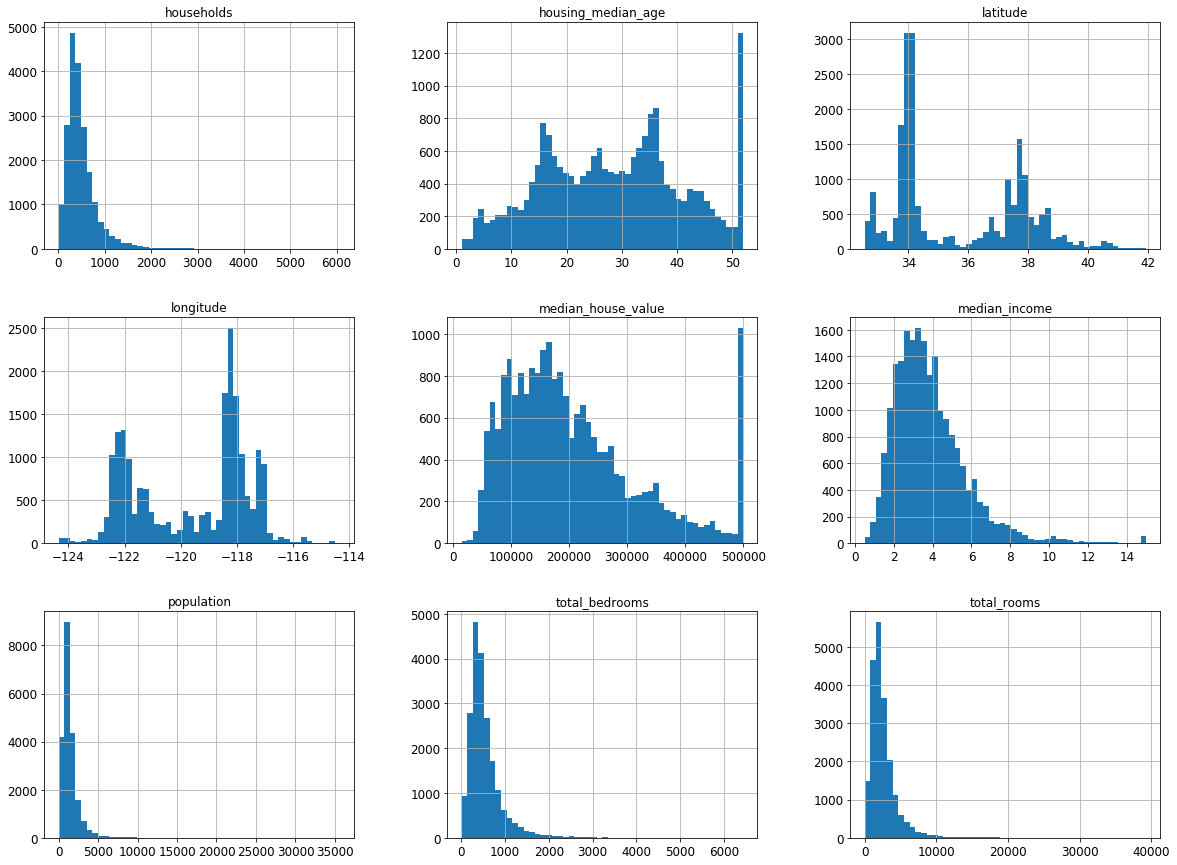

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
# Para tornar a saída deste notebook identica em todas as execuções
np.random.seed(42)

In [11]:
import numpy as np


# Função que divide o DataFrame em dois grupos: treino e teste
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
# Dividindo o DataFrame housing com 80% de treino e 20% de teste
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [13]:
from zlib import crc32


# Calcular o hash do index de cada instância para fixar as instancias teste
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
# Criando a coluna com o index a partir do index do DataFrame
housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
# Criando um calculo para definir o ID da instância 
# Tratando possiveis index deletados
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


Todos estes passos realizados acima podem ser substituidos pela função `train_test_split`, presente na biblioteca sklearn

In [17]:
# Função que faz o split automatico na biblioteca sklearn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Vamos considerar que a _feature_ `median_income` possui extrema relevância para o balanceamento do dataset. Sendo assim, é de extrema importância que a distribuição desta _feature_ seja semelhante ao dataset original, tanto no dataset de treino quanto no de teste.

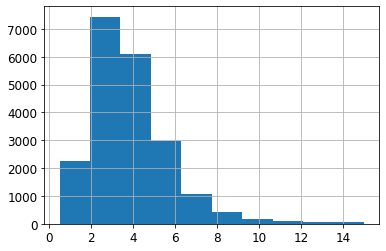

In [19]:
# Apresentando o histograma com a coluna 'median_income'
housing["median_income"].hist();

In [20]:
# Categorizando a feature 'median_income' para facilitar visualização
# 5 Categorias: 1: menos que $15.000, 2: de $15.000 a $30.000 ... 
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [21]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

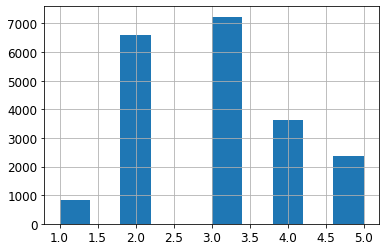

In [22]:
housing["income_cat"].hist()

Vamos então dividir o dataset utilizando a função `StratifiedShuffleSplit` disponível na biblioteca sklearn, de maneira que conseguimos definir no método `split.split` qual _feature_ será utilizada para auxiliar na divisão do dataset.

In [23]:
# Dividindo o dataset em treino e teste seguindo as proporções da coluna 'income_cat'
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
# Conferindo a proporção dos dados de teste
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [25]:
# Conferindo a proporção do dataset completo (muito semelhante ao de teste)
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Note que as proporções ficaram extremamente próximas, atendendo ao que se foi proposto.

In [26]:
# Função que calcula a proporção das partes dos dados da feature 'income_cat'
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Criando DataFrame compare_props com as comparações ordenadas pelo index
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

# Adicionando ao DataFrame compare_props o erro ao se utilizar a divisão randomica
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100

# Adicionando ao DataFrame compare_props o erro ao se utilizar a divisão estratificada
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
# Imprimindo o DataFrame compare_props
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Observe que o erro presente ao se fazer a divisão randomizada é muito maior do que o erro obtido ao se pensar para efetuar a divisão, realizando a mesma de maneira estratificada.

In [28]:
# Removendo a coluna 'income_cat' dos DataFrames de treino e teste
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Descubra e Visualize os Dados para Obter Insights

In [29]:
# Obtendo o dataset de treino estratificado
housing = strat_train_set.copy()

## 3.1 Visualizando Dados Geográficos

Como há informações geográficas no dataset (latitude e longitude), pode ser interessante criar um gráfico de dispersão de todos os distritos para visualizar os dados.

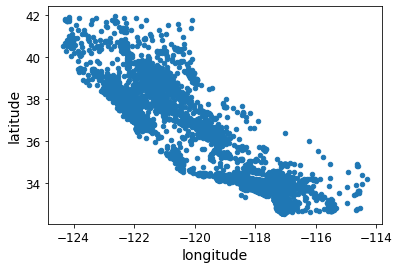

In [30]:
# Plotando um scatterplot com longitude no X e latitude no Y
housing.plot(kind="scatter", x="longitude", y="latitude");

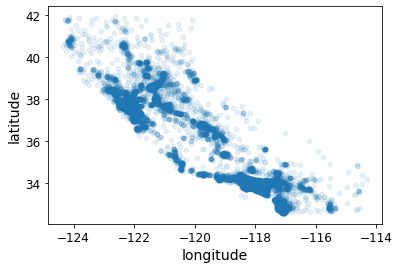

In [31]:
# Plotando o mesmo scatterplot com alpha = 0.1 para visualizar a densidade
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Agora está muito melhor: você pode ver claramente as áreas de alta densidade, ou seja, a Bay Area e ao redor de Los Angeles e San Diego, além de uma longa linha de densidade bastante alta no Vale Central, em particular ao redor de Sacramento e Fresno.

O argumento `sharex = False` corrige um bug de exibição (os valores do eixo x e a legenda não foram exibidos). Esta é uma correção temporária (consulte: https://github.com/pandas-dev/pandas/issues/10611).

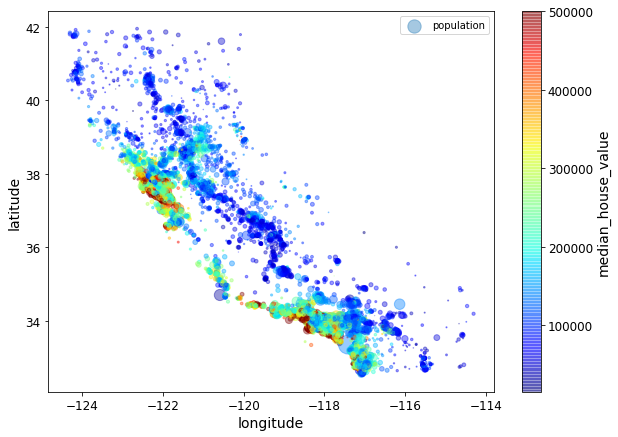

In [32]:
# Plotagem da latitude e longitude considerando agora a população (tamanho dos circulos) e o preço médio (cores dos circulos)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.legend()

Esta imagem informa que os preços das moradias estão muito relacionados com a localização (por exemplo, perto do oceano) e com a densidade populacional. Provavelmente será útil usar um algoritmo de agrupamento para detectar os clusters principais e adicionar novos recursos que medem a proximidade dos centros do cluster. O atributo de proximidade do oceano também pode ser útil.

In [33]:
# Baixando a imagem com o mapa da California (para o background)
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")

os.makedirs(images_path, exist_ok=True)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"

url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename

urllib.request.urlretrieve(url, os.path.join(images_path, filename));

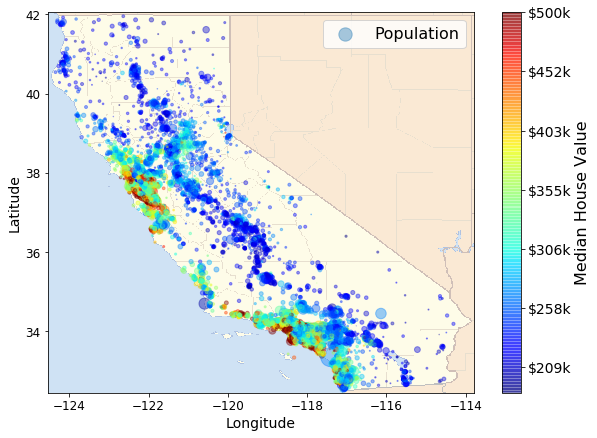

In [34]:
# Realizando a mesma plotagem sobre o mapa da costa da California
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 7),
                       s=housing['population'] / 100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)

cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000))
                         for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## 3.2 Analisando as Correlações

Como o conjunto de dados não é muito grande, pode-se calcular facilmente o coeficiente de correlação padrão (também chamado de r de Pearson) entre cada par de atributos usando o método `corr()`:

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

O coeficiente de correlação varia de -1 a 1. Quando próximo de 1, significa que existe uma correlação positiva forte; por exemplo, o valor mediano da casa tende a aumentar quando a renda mediana aumenta. Quando o coeficiente está próximo de -1, significa que há uma forte correlação negativa; você pode ver uma pequena correlação negativa entre a latitude e o valor médio da casa (ou seja, os preços têm uma ligeira tendência de cair quando você vai para o norte). Finalmente, coeficientes próximos de zero significam que não há correlação linear.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa21f3a2150>,
      dtype=object)

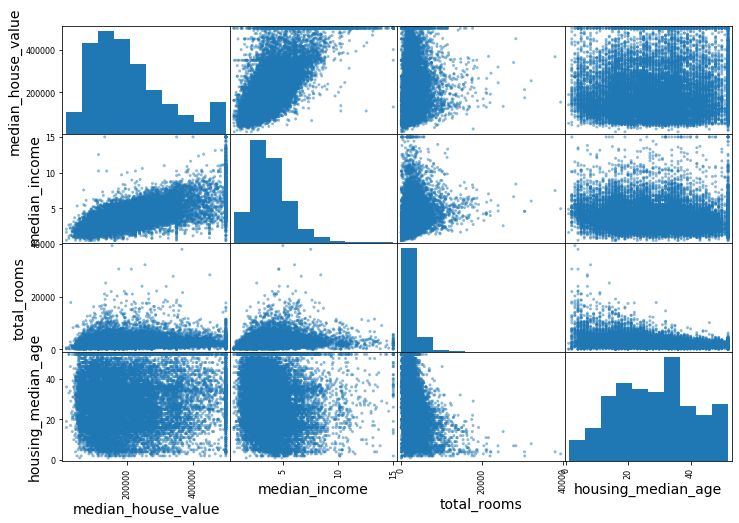

In [37]:
# Plotando a scatter_matrix de certas features para observar a correlação
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

O atributo mais promissor para prever o valor médio da casa é a média da renda, então vamos ampliar seu gráfico de dispersão da correlação abaixo.

[0, 16, 0, 550000]

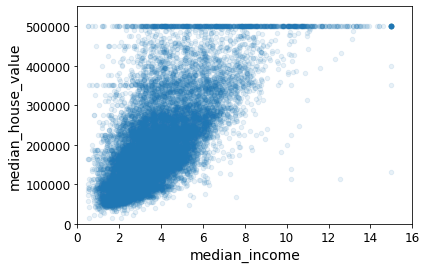

In [38]:
# Plotando o gráfico de dispersão entre o valor médio da casa e a renda média
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

plt.axis([0, 16, 0, 550000])

Note que a correlação é forte. Pode ser visto claramente a tendência de alta e os pontos não estão muito dispersos.

## 3.3 Experimentando Combinações de Atributos

Vamos experimentar criar novas _features_, realizando a combinação de certas _features_. Por exemplo, o número total de quartos em um distrito não é muito útil se você não sabe quantas famílias existem. O que você realmente deseja é o número de comodos por família. Da mesma forma, o número total de quartos por si só não é muito útil. Você provavelmente deseja compará-lo com o número de cômodos. E a população por família também parece uma combinação de atributos interessante para se observar. 

Vamos criar estas novas _features_:

In [39]:
# Criando a feature comodos por família 
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

# Criando a feature quarto por cômodo
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]

# Criando a feature população por família
housing["population_per_household"] = housing["population"] / housing["households"]

Agora vamos observar a correlação das novas _features_ com o label _median_house_value_:

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

A nova _feature_ `bedrooms_per_room` está muito mais correlacionado com o valor médio da casa do que o número total de quartos ou cômodos. Aparentemente, as casas com uma relação quarto/cômodo menor tendem a ser mais caras. O número de quartos por família `rooms_per_household` também é mais informativo do que o número total de quartos em um distrito - obviamente, quanto maiores as casas, mais caras elas são.

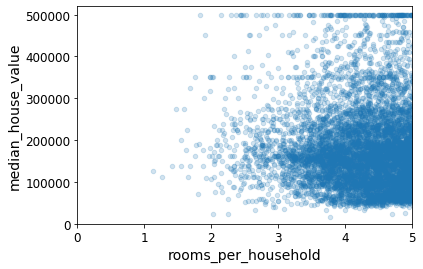

In [41]:
# Plotando o gráfico de dispersão entre o valor médio da casa e a número de cômodos por residência
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## 4 Preparando os Dados para Algoritmos de Aprendizado de Máquina

É hora de preparar os dados para seus algoritmos de aprendizado de máquina. Mas primeiro vamos reverter para um conjunto de treinamento limpo (copiando `strat_train_set` mais uma vez) e vamos separar os preditores e os rótulos (_labels_), já que não queremos necessariamente aplicar as mesmas transformações aos preditores e aos valores alvo.

In [42]:
# Removendo os rótulos (labels) do dataset de treino
housing = strat_train_set.drop("median_house_value", axis=1) 

# Salvando os rótulos (labels) do dataset de treino 
housing_labels = strat_train_set["median_house_value"].copy()

## 4.1 Limpeza dos Dados

A maioria dos algoritmos de aprendizado de máquina não funciona com valores faltantes (NaNs), então vamos criar algumas funções para cuidar deles.

In [43]:
# Mostrando apenas as linhas que possuem algum valor NaN
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()

sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [44]:
# Opção 1: Remova as colunas (features) com valores NaN
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [45]:
# Opção 2: Remova as linhas (atributos) com valores NaN
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [46]:
# Opção 3: Preencha os NaNs com algum valor (neste caso com a mediana)
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [47]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Se você escolher a Opção 3, deve calcular o valor mediano no conjunto de treinamento e usá-lo para preencher os valores ausentes no conjunto de treinamento, mas também não se esqueça de salvar o valor mediano que você calculou. Você precisará dele mais tarde para substituir os valores ausentes no conjunto de teste quando quiser avaliar seu sistema e também quando o sistema entrar em operação para substituir os valores ausentes em novos dados.

O Scikit-Learn oferece uma classe útil para cuidar de valores ausentes: `SimpleImputer`. Aqui está como usá-la. Primeiro, você precisa criar uma instância com o `SimpleImputer`, especificando que deseja substituir os valores ausentes de cada atributo pela mediana desse atributo:

In [48]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Como a mediana só pode ser calculada em atributos numéricos, precisamos criar uma cópia dos dados sem a _feature_ de texto `ocean_proximity`:

In [49]:
housing_num = housing.drop("ocean_proximity", axis=1)

Agora você pode ajustar a instância aos dados de treinamento usando o método `fit()`:

In [50]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

O imputador simplesmente calculou a mediana de cada _feature_ e armazenou o resultado em sua variável de instância `statistics_`. Apenas a _feature_ `total_bedrooms` tinha valores ausentes, mas não podemos ter certeza de que não haverá nenhum valor ausente nos novos dados depois que o sistema entrar em operação, então é mais seguro aplicar o imputador a todos os atributos numéricos:

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Agora você pode usar este imputador "treinado" para transformar o conjunto de treinamento, substituindo os valores ausentes pelas medianas aprendidas:

In [52]:
X = imputer.transform(housing_num)

O resultado é uma matriz NumPy simples contendo os recursos transformados. Se você quiser colocá-lo de volta em um DataFrame do Pandas:

In [53]:
imputer.strategy

'median'

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [55]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## 4.2 Manipulação de Texto e Features Categóricas

Anteriormente, deixamos de fora a _feature_ categórica `ocean_proximity` pois é do tipo texto, portanto, não podemos calcular sua mediana:

In [56]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


A maioria dos algoritmos de aprendizado de máquina prefere trabalhar com números de qualquer maneira, então vamos converter essas categorias de texto em números. Para isso, podemos usar a classe `OrdinalEncoder` do Scikit-Learn.

In [57]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

Você pode obter a lista de categorias usando a instância `categories_`. É uma lista que contém uma matriz de uma dimensão de categorias para cada _feautre_ categórica.

In [58]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Um problema com essa representação é que os algoritmos de aprendizado de máquina assumirão que dois valores próximos são mais semelhantes do que dois valores distantes. Isso pode ser bom em alguns casos (por exemplo, para categorias ordenadas como "ruim", "médio", "bom", "excelente"), mas obviamente não é o caso para a coluna `ocean_proximity`.

Para corrigir esse problema, uma solução comum é criar um atributo (_feature_) binário por categoria: um atributo igual a 1 quando a categoria é “<1H OCEAN” (e 0 caso contrário), outro atributo igual a 1 quando a categoria é “INLAND” (e 0 caso contrário), e assim por diante. Isso é chamado de _one-hot encoding_, porque apenas um atributo será igual a 1 (hot), enquanto os outros serão 0 (cold).

In [59]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

# Realizando o One-Hot Encoding nas features categoricas
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Por padrão, a classe `OneHotEncoder` retorna uma matriz esparsa, mas podemos convertê-la em uma matriz densa, se necessário, chamando o método `toarray()`:

In [60]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Como alternativa, você pode definir `sparse = False` ao criar o `OneHotEncoder`:

In [61]:
cat_encoder = OneHotEncoder(sparse=False)

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [62]:
# Categorias considerads durante o One-Hot Encoding
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 4.3 Transformadores Personalizados

Embora o Scikit-Learn forneça muitos transformadores úteis, você pode precisar escrever os seus próprios para tarefas como operações de limpeza personalizadas ou combinação de atributos específicos. Você vai querer que seu transformador funcione perfeitamente com as funcionalidades do Scikit-Learn (como pipelines) e tudo que você precisa é criar uma classe e implementar três métodos: `fit()` (retornando self), `transform()` e `fit_transform()`. Você pode obter o último gratuitamente simplesmente adicionando `TransformerMixin` como uma classe base. 

Além disso, se você adicionar `BaseEstimator` como uma classe base (e evitar *args e ** kargs em seu construtor), você obterá dois métodos extras (`get_params()` e `set_params()`) que serão úteis para tunar hipermarâmetros automaticamente.

Por exemplo, aqui está uma pequena classe de transformador que adiciona os atributos (_features_) combinados que discutimos anteriormente:

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

# Index das colunas
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # Sem *args ou **kargs no init
    def __init__(self, add_bedrooms_per_room=True):  
        self.add_bedrooms_per_room = add_bedrooms_per_room

    # Nada a se fazer
    def fit(self, X, y=None):
        return self  

    # Transformando as features de X
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Inicializando a classe criada sem a feature 'bedrooms_per_room'
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# Utilizando o método transform da classe criada em housing.values
housing_extra_attribs = attr_adder.transform(housing.values)

In [64]:
# Criando um DataFrame a partir do retorno obtido
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## 4.4 Feature Scaling

Uma das transformações mais importantes que você precisa aplicar aos seus dados é o dimensionamento de recursos. Com poucas exceções, os algoritmos de aprendizado de máquina não funcionam bem quando os atributos numéricos de entrada têm escalas muito diferentes. Este é o caso para os dados de habitação: o número total de quartos varia de cerca de 6 a 39.320, enquanto as rendas medianas variam apenas de 0 a 15.

Existem duas maneiras comuns de fazer com que todos os atributos tenham a mesma escala: _min-max scalling_ e _standardization_.

O _min-max scalling_ (muitas pessoas chamam isso de normalização) é bastante simples: os valores são deslocados e redimensionados para que acabem variando de 0 a 1.

A _standardization_ é bem diferente: primeiro ela subtrai o valor médio (portanto, os valores padronizados sempre têm uma média zero) e depois divide pelo desvio padrão para que a distribuição resultante tenha variância unitária. Ao contrário do _min-max scalling_, a _standardization_ não vincula valores a uma faixa específica, o que pode ser um problema para alguns algoritmos (por exemplo, as redes neurais geralmente esperam um valor de entrada que varia de 0 a 1). No entanto, a _standardization_ é muito menos afetada por outliers.

Como acontece com todas as transformações, é **importante ajustar as escalas apenas aos dados de treinamento, não ao conjunto de dados completo (incluindo o conjunto de teste)**. Só então você pode usá-los para transformar o conjunto de treinamento e o conjunto de teste (e novos dados).

## 4.5 Pipelines de Transformação

Como você pode ver, há muitas etapas de transformação de dados que precisam ser executadas na ordem certa. Felizmente, o Scikit-Learn fornece a classe Pipeline para ajudar com essas sequências de transformações. Aqui está um pequeno pipeline para os atributos numéricos:

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Criando um pipeline que: 1- preenche os valores NaN com a mediana,
#                          2- utiliza a classe CombinedAttributesAdder criada para manipulação das features,
#                          3- faz a normalização dos dados usando Standardization.
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Criando o array housing_num_tr com as transformações do pipeline
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [66]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Até agora, tratamos as colunas categóricas e as colunas numéricas separadamente. Seria mais conveniente ter um único transformador capaz de lidar com todas as colunas, aplicando as transformações apropriadas a cada coluna. Abaixo utilizamos a função `ColumnTransformer` com este propósito.

In [67]:
from sklearn.compose import ColumnTransformer

# Definindo os atributos (features) numéricos
num_attribs = list(housing_num)

# Definindo os atributos (features) categóricos
cat_attribs = ["ocean_proximity"]

# Criando um pipeline que: 1 - usa o pipeline numérico nos atributos numéricos
#                          2 - realiza o One-Hot Encoding nos atributos categóricos
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [68]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [69]:
housing_prepared.shape

(16512, 16)

# 5 Selecione e Treine um Modelo

Você estruturou o problema, obteve os dados e os explorou, amostrou um conjunto de treinamento e um conjunto de teste e escreveu pipelines de transformação para limpar e preparar seus dados para algoritmos de aprendizado de máquina automaticamente. Agora você está pronto para selecionar e treinar um modelo de aprendizado de máquina.

## 5.1 Treinamento e Avaliação no Conjunto de Treinamento

Graças a todas essas etapas anteriores, as coisas agora serão muito mais simples do que você imagina. Vamos treinar um modelo de Regressão Linear:

In [70]:
from sklearn.linear_model import LinearRegression

# Criando e ajustando o modelo de Regressão Linear
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Vamos experimentar o modelo em algumas instâncias do conjunto de treinamento:

In [71]:
# Selecionando apenas alguns dados do DataFrame
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Rodando o pipeline sobre os dados selecionados
some_data_prepared = full_pipeline.transform(some_data)

# Gerando a predição sobre os dados selecionados
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Comparando com os valores reais do custo:

In [72]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Note que a predição funciona, embora as previsões não sejam extremamente precisas (por exemplo, a primeira previsão está errada em cerca de 40%!). Vamos medir o RMSE deste modelo de regressão em todo o conjunto de treinamento usando a função `mean_squared_error` do Scikit-Learn:

In [73]:
from sklearn.metrics import mean_squared_error

# Gerando a predição de todo os dados tratados
housing_predictions = lin_reg.predict(housing_prepared)

# Obtendo o MSE e o RMSE do modelo
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Claramente não é uma grande pontuação: o `median_housing_values` da maioria dos distritos varia entre 120.000 e 265.000, então um erro de previsão típico de 68.628 não é muito satisfatório. Este é um exemplo de modelo que não se ajusta aos dados de treinamento (_underfitting_). Quando isso acontece, pode significar que os recursos não fornecem informações suficientes para fazer boas previsões ou que o modelo não é poderoso o suficiente.

Vamos treinar um `DecisionTreeRegressor`. Este é um modelo poderoso, capaz de encontrar relacionamentos não lineares complexos nos dados.

In [74]:
from sklearn.tree import DecisionTreeRegressor

# Criando e ajustando o modelo de Árvore de Decisão
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [75]:
# Gerando a predição de todo os dados tratados
housing_predictions = tree_reg.predict(housing_prepared)

# Obtendo o MSE e o RMSE do modelo
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Espere o que!? Nenhum erro? Este modelo poderia ser absolutamente perfeito? Obviamente, é muito mais provável que o modelo tenha superestimado os dados (_overfitting_). Como você pode ter certeza? Como vimos anteriormente, você não quer tocar no conjunto de teste até que esteja pronto para lançar um modelo no qual esteja confiante, então você precisa usar parte do conjunto de treinamento para treinamento e parte para validação do modelo.

## 5.2 Melhor Avaliação Usando Validação Cruzada

Uma maneira de avaliar o modelo de árvore de decisão seria usar a função `train_test_split` para dividir o conjunto de treinamento em um conjunto de treinamento menor e um conjunto de validação, então treinar seus modelos contra o conjunto de treinamento menor e avaliá-los em relação ao conjunto de validação.

Uma ótima alternativa é usar o recurso de validação cruzada _K-fold cross validation_ do Scikit-Learn. O código a seguir divide aleatoriamente o conjunto de treinamento em 10 subconjuntos distintos chamados _folds_, então ele treina e avalia o modelo de árvore de decisão 10 vezes, escolhendo um _fold_ diferente para avaliação a cada vez e treinando nos outros 9 _folds_. O resultado é uma matriz contendo as 10 pontuações da avaliação:

In [76]:
from sklearn.model_selection import cross_val_score

# Calculando as pontuações do k-fold cross validation para a árvore de decisão
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

# Convertendo o MSE em RMSE
tree_rmse_scores = np.sqrt(-scores)

In [77]:
# Criando uma função que apresenta os scores do k-fold cross validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Agora, com estes resultados, a árvore de decisão não parece tão boa quanto antes. Na verdade, parece ter um desempenho pior do que o modelo de regressão linear. Observe que a validação cruzada permite obter não apenas uma estimativa do desempenho do seu modelo, mas também uma medida de quão precisa essa estimativa é (ou seja, seu desvio padrão). A Árvore de Decisão tem uma pontuação de aproximadamente 71.407, geralmente ± 2.439. Você não teria essas informações se apenas usasse um conjunto de validação. Mas a validação cruzada vem com o custo de treinar o modelo várias vezes, portanto, nem sempre é possível.

Vamos calcular as mesmas pontuações para o modelo de regressão linear apenas para ter certeza:

In [78]:
# Calculando as pontuações do k-fold cross validation para a regressão linear
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

# Convertendo o MSE em RMSE
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


O modelo da Árvore de Decisão está com tanto overfitting que tem um desempenho pior do que o modelo de Regressão Linear.

Vamos tentar um último modelo agora: o `RandomForestRegressor`:

In [79]:
from sklearn.ensemble import RandomForestRegressor

# Criando e ajustando o modelo de Floresta Randômica
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [80]:
# Gerando a predição de todo os dados tratados
housing_predictions = forest_reg.predict(housing_prepared)

# Obtendo o MSE e o RMSE do modelo
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [81]:
from sklearn.model_selection import cross_val_score

# Calculando as pontuações do k-fold cross validation para a árvore randômica
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

# Convertendo o MSE em RMSE
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


_Random forests_ parecem muito promissoras. No entanto, observe que a pontuação no conjunto de treinamento (18603) ainda é muito menor do que nos conjuntos de validação (50182), o que significa que o modelo ainda está com _overfitting_ do conjunto de treinamento. As soluções possíveis para _overfitting_ são simplificar o modelo, restringi-lo ou obter mais dados de treinamento.

# 6 Ajuste seu Modelo

Suponhamos que agora você tenha uma lista de modelos promissores. Agora você precisa ajustá-los. Vejamos algumas maneiras de fazer isso.

## 6.1 Grid Search

Uma maneira de fazer isso seria mexer nos hiperparâmetros manualmente, até encontrar uma ótima combinação de valores de hiperparâmetros. Isso seria um trabalho muito tedioso e você pode não ter tempo para explorar muitas combinações.

Em vez disso, você deve obter o `GridSearchCV` do Scikit-Learn para pesquisar por você. Tudo o que você precisa fazer é dizer a ele quais hiperparâmetros deseja experimentar e quais valores experimentar, e ele avaliará todas as combinações possíveis de valores de hiperparâmetros, usando validação cruzada. Por exemplo, o código a seguir procura a melhor combinação de valores de hiperparâmetros para o `RandomForestRegressor`:

In [82]:
from sklearn.model_selection import GridSearchCV

# Criando dois dicionários com os hiperparâmetros e valores a serem treinados
param_grid = [
    # Primeiro treinaremos com 12 (4x3) variações em n_estimators e max_features
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Em seguida treinaremos com 6 (1x2x3) variações em n_estimator e max_features com bootstrap=False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

# Criando o modelo de Árvore Randômica
forest_reg = RandomForestRegressor(random_state=42)

# Criando e ajustando com 5 folds, um total de 90 rodadas de treinos (12+6) * 5
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Quando você não tem ideia de qual valor um hiperparâmetro deve ter, uma abordagem simples é experimentar potências consecutivas de 10

Os melhores valores para os hiperparâmetros encontrados desta Grid Search são:

In [83]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Sendo assim, o melhor modelo encontrado possui os seguintes hiperparâmetros:

In [84]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Vejamos a pontuação de cada combinação de hiperparâmetros testada durante a _Search Grid_:

In [85]:
# Salvando os resultados do grid search na variável cvres
cvres = grid_search.cv_results_

# Imprimindo a combinação dos parâmetros testados e suas respectivas pontuações
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [86]:
# Apresentando todos os valores retornados pelo grid search
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.063476,0.002633,0.003266,0.000151,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.198328,0.004291,0.008829,0.000116,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.651035,0.042268,0.026489,0.001227,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.166369,0.010530,0.004646,0.000301,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.568723,0.019274,0.014914,0.002313,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.291784,0.137226,0.030369,0.004141,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.159246,0.005676,0.003958,0.000393,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.518282,0.020135,0.009868,0.000339,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.755491,0.204204,0.031142,0.004019,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.212396,0.015592,0.003830,0.000250,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## 6.2 Busca Randomizada

A abordagem de _Grid Search_ é boa quando você está explorando relativamente poucas combinações, como no exemplo anterior, mas quando o espaço de pesquisa de hiperparâmetros é grande, geralmente é preferível usar `RandomizedSearchCV`. Esta classe pode ser usada da mesma forma que a classe `GridSearchCV`, mas em vez de tentar todas as combinações possíveis, ela avalia um determinado número de combinações aleatórias selecionando um valor aleatório para cada hiperparâmetro a cada iteração.

In [87]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Criando um dicionário com os hiperparâmetros e range de valores a serem treinados
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

# Criando o modelo de Árvore Randômica
forest_reg = RandomForestRegressor(random_state=42)

# Criando e ajustando com 5 folds
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [88]:
# Salvando os resultados do grid search na variável cvres
cvres = rnd_search.cv_results_

# Imprimindo a combinação dos parâmetros testados e suas respectivas pontuações
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


## 6.3 Agrupando Métodos

Outra forma de ajustar seu sistema é tentar combinar os modelos que apresentam melhor desempenho. O grupo geralmente terá um desempenho melhor do que o melhor modelo individual (assim como as Florestas Aleatórias têm um desempenho melhor do que as Árvores de Decisão individuais), especialmente se os modelos individuais cometerem tipos de erros muito diferentes.

## 6.4 Analisando os Melhores Modelos e seus Erros

Freqüentemente, você obterá bons insights sobre o problema inspecionando os melhores modelos. Por exemplo, o `RandomForestRegressor` pode indicar a importância relativa de cada _feature_ para fazer previsões precisas:

In [89]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Vamos exibir essas pontuações de importância ao lado dos nomes das _features_ correspondentes:

In [90]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

Com essas informações, você pode tentar descartar algumas das _features_ menos úteis (por exemplo, aparentemente, apenas uma categoria da _feature_ `ocean_proximity` é realmente útil, então você pode tentar descartar as outras).

## 6.5 Avalie seu Sistema no Conjunto de Teste

Depois de ajustar seus modelos por um tempo, você finalmente terá um sistema que funciona suficientemente bem. Agora é a hora de avaliar o modelo final do conjunto de teste. Não há nada de especial neste processo; apenas obtenha os preditores e os rótulos de seu conjunto de teste, execute seu `full_pipeline` para transformar os dados (chame `transform()`, não `fit_transform()`, você não deseja ajustar ao conjunto de teste!) e avalie o modelo final no conjunto de teste:

In [91]:
# O modelo final é o melhor modelo obitdo pela grid search
final_model = grid_search.best_estimator_

# Delimitando X como entrada, com o dataframe sem o label e o Y como saída (label)
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transformando os dados de teste assim como foram transformados os de treino
X_test_prepared = full_pipeline.transform(X_test)

# Realizando as predições sobre os dados de teste
final_predictions = final_model.predict(X_test_prepared)

# Obtendo os scores para os dados de teste
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [92]:
final_rmse

47730.22690385927

Em alguns casos, essa estimativa pontual do erro de generalização não será suficiente para convencê-lo a lançar: e se for apenas 0,1% melhor do que o modelo atualmente em produção? Você pode querer ter uma ideia de quão precisa é essa estimativa. Para isso, você pode calcular um intervalo de confiança de 95% para o erro de generalização usando `scipy.stats.t.interval()`:

In [93]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

O intervalo de confiança então é [45685.1, 49691.2].

# 7 Apresente sua Solução

Agora vem a fase de pré-lançamento do projeto: você precisa apresentar sua solução (destacando o que você aprendeu, o que funcionou e o que não funcionou, quais suposições foram feitas e quais são as limitações do seu sistema), documentar tudo e criar apresentações agradáveis com visualizações claras e afirmações fáceis de lembrar (por exemplo, “a renda mediana é o indicador número um dos preços da habitação”). Neste exemplo de habitação da Califórnia, o desempenho final do sistema não é melhor do que o dos especialistas, mas ainda pode ser uma boa ideia lançá-lo, especialmente se isso liberar algum tempo para que os especialistas possam trabalhar mais em tarefas mais interessantes e produtivas.

# 8 Inicie, Monitore e Mantenha seu Sistema

Agora você precisa preparar sua solução para produção, em particular conectando as fontes de dados de entrada de produção em seu sistema e escrevendo testes. 

Você também precisa escrever um código de monitoramento para verificar o desempenho ao vivo do seu sistema em intervalos regulares e acionar alertas quando ele cair. Isso é importante para detectar não apenas uma quebra repentina, mas também a degradação do desempenho. Isso é bastante comum porque os modelos tendem a “apodrecer” conforme os dados evoluem ao longo do tempo, a menos que os modelos sejam regularmente treinados com dados novos.

Você também deve avaliar a qualidade dos dados de entrada do sistema. Às vezes, o desempenho degradará um pouco por causa de um sinal de baixa qualidade (por exemplo, um sensor com defeito enviando valores aleatórios ou a saída de outra equipe se tornando obsoleta), mas pode demorar um pouco antes que o desempenho do seu sistema seja degradado o suficiente para acionar um alerta. Se você monitorar as entradas do seu sistema, você pode perceber isso mais cedo.

Finalmente, você geralmente desejará treinar seus modelos regularmente usando dados novos. Você deve automatizar esse processo tanto quanto possível. Do contrário, é muito provável que você atualize seu modelo apenas a cada seis meses (na melhor das hipóteses), e o desempenho do sistema pode flutuar severamente ao longo do tempo.